# Исследование по GMTS

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [120]:
# Загрузка 5 минутных данных
df = pd.read_csv('br_m5_TVI_CCI_T3_GHL.csv')
df['tradedate'] = pd.to_datetime(df['tradedate'])

df

,tradedate,open,high,low,close,tvi,cci,t3,ghl
0,2015-01-05 10:00:00,57.05,57.05,55.12,55.43,0,0,0,0
1,2015-01-05 10:05:00,55.43,55.46,55.37,55.45,1,0,1,0
2,2015-01-05 10:10:00,55.45,55.45,55.33,55.33,1,0,-1,0
3,2015-01-05 10:15:00,55.34,55.38,55.20,55.25,1,0,-1,-1
4,2015-01-05 10:20:00,55.27,55.36,55.27,55.31,1,0,-1,0
...,...,...,...,...,...,...,...,...,...
409072,2024-12-30 23:25:00,74.41,74.42,74.39,74.41,1,1,1,1
409073,2024-12-30 23:30:00,74.41,74.42,74.40,74.41,1,1,1,1
409074,2024-12-30 23:35:00,74.41,74.42,74.40,74.41,1,1,1,1
409075,2024-12-30 23:40:00,74.42,74.42,74.40,74.42,1,1,1,1


Создание дата фрейма с колонкой **'buy_sell'** признаков открытия позиции Bay или Sell.

In [121]:
# Проверка, являются ли все значения в строке одинаковыми [1, 1, 1, 1] или [-1, -1, -1, -1]
df['IsAllSame'] = df[['tvi', 'cci', 't3', 'ghl']].eq(1).all(axis=1) | \
    df[['tvi', 'cci', 't3', 'ghl']].eq(-1).all(axis=1)

# Находим группы последовательных строк, где IsAllSame == True
df['Group'] = (df['IsAllSame'] != df['IsAllSame'].shift(1)).cumsum()

# Отмечаем только вторую строку в каждой группе, где IsAllSame == True
df['SecondInRow'] = df.groupby('Group').cumcount() == 1
df.loc[~df['IsAllSame'], 'SecondInRow'] = False  # Убираем строки, где IsAllSame == False

# Добавляем колонку 'sig', отмечаем только вторую строку в последовательности
df['sig'] = 0
df.loc[df['SecondInRow'], 'sig'] = 1

# Убираем вспомогательную колонку 'Group', 'IsAllSame', 'SecondInRow'
df.drop(columns=['Group', 'IsAllSame', 'SecondInRow'], inplace=True)

# Добавляем колонку с ценой открытия по сигналу
df['sig_open'] = df.apply(lambda x: x.open if x.sig == 1 else 0, axis=1)

# Добавляем колонку с направлением торговли
conditions = [
    (df['tvi'] == 1) & (df['cci'] == 1) & (df['t3'] == 1) & (df['ghl'] == 1) & (df['sig'] == 1),
    (df['tvi'] == -1) & (df['cci'] == -1) & (df['t3'] == -1) & (df['ghl'] == -1) & (df['sig'] == 1)
]
choices = [1, -1]
df['buy_sell'] = np.select(conditions, choices, default=0)

df

,tradedate,open,high,low,close,tvi,cci,t3,ghl,sig,sig_open,buy_sell
0,2015-01-05 10:00:00,57.05,57.05,55.12,55.43,0,0,0,0,0,0.00,0
1,2015-01-05 10:05:00,55.43,55.46,55.37,55.45,1,0,1,0,0,0.00,0
2,2015-01-05 10:10:00,55.45,55.45,55.33,55.33,1,0,-1,0,0,0.00,0
3,2015-01-05 10:15:00,55.34,55.38,55.20,55.25,1,0,-1,-1,0,0.00,0
4,2015-01-05 10:20:00,55.27,55.36,55.27,55.31,1,0,-1,0,0,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...
409072,2024-12-30 23:25:00,74.41,74.42,74.39,74.41,1,1,1,1,1,74.41,1
409073,2024-12-30 23:30:00,74.41,74.42,74.40,74.41,1,1,1,1,0,0.00,0
409074,2024-12-30 23:35:00,74.41,74.42,74.40,74.41,1,1,1,1,0,0.00,0
409075,2024-12-30 23:40:00,74.42,74.42,74.40,74.42,1,1,1,1,0,0.00,0


Создаем колонку **"profit"** в которую записываем:  
если значение в колонке 'buy_sell' равно 1, то из ближайшего последующего значения в колонке 'sig_open' не равного 0, вычесть текущее значение в колонке 'sig_open'  
если значение в колонке 'buy_sell' равно -1, то из текущего значения в колонке 'sig_open', вычесть ближайшее последующее значение в колонке 'sig_open' не равное 0  
иначе, записать в колонку 0

In [122]:
def calculate_profit(row, sig_open_col, buy_sell_col):
    # Индекс текущей строки
    current_index = row.name

    # Значение buy_sell для текущей строки
    buy_sell = row[buy_sell_col]
    sig_open = row[sig_open_col]

    # Если buy_sell равно 1
    if buy_sell == 1:
        # Найти ближайшее последующее значение в sig_open, не равное 0
        for next_value in df.loc[current_index + 1:, sig_open_col]:
            if next_value != 0:
                return next_value - sig_open

    # Если buy_sell равно -1
    elif buy_sell == -1:
        # Найти ближайшее последующее значение в sig_open, не равное 0
        for next_value in df.loc[current_index + 1:, sig_open_col]:
            if next_value != 0:
                return sig_open - next_value

    # Если buy_sell не равно 1 или -1
    return 0

# Применить функцию ко всем строкам
df['profit'] = df.apply(calculate_profit, axis=1, sig_open_col='sig_open', buy_sell_col='buy_sell')

# Результат
df

,tradedate,open,high,low,close,tvi,cci,t3,ghl,sig,sig_open,buy_sell,profit
0,2015-01-05 10:00:00,57.05,57.05,55.12,55.43,0,0,0,0,0,0.00,0,0.0
1,2015-01-05 10:05:00,55.43,55.46,55.37,55.45,1,0,1,0,0,0.00,0,0.0
2,2015-01-05 10:10:00,55.45,55.45,55.33,55.33,1,0,-1,0,0,0.00,0,0.0
3,2015-01-05 10:15:00,55.34,55.38,55.20,55.25,1,0,-1,-1,0,0.00,0,0.0
4,2015-01-05 10:20:00,55.27,55.36,55.27,55.31,1,0,-1,0,0,0.00,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
409072,2024-12-30 23:25:00,74.41,74.42,74.39,74.41,1,1,1,1,1,74.41,1,0.0
409073,2024-12-30 23:30:00,74.41,74.42,74.40,74.41,1,1,1,1,0,0.00,0,0.0
409074,2024-12-30 23:35:00,74.41,74.42,74.40,74.41,1,1,1,1,0,0.00,0,0.0
409075,2024-12-30 23:40:00,74.42,74.42,74.40,74.42,1,1,1,1,0,0.00,0,0.0


Фильтрация

In [123]:
# Очистка df
df = df[df["profit"] != 0.0]

# Фильтрация строк с марта 2015 и времени до 19:00:00
df = df[
    (df["tradedate"] >= pd.Timestamp("2015-03-01")) & 
    (df["tradedate"].dt.time < pd.to_datetime("19:00:00").time())
]

df = df.copy().reset_index(drop=True)

# Добавление колонки с датой
df['date'] = df['tradedate'].dt.date

# Добавление колонки с временем
df['time'] = df['tradedate'].dt.time

# Учет спреда при симуляции торговли
df["profit"] = df["profit"] - 0.01

df

,tradedate,open,high,low,close,tvi,cci,t3,ghl,sig,sig_open,buy_sell,profit,date,time
0,2015-03-02 10:15:00,62.03,62.03,61.83,61.84,-1,-1,-1,-1,1,62.03,-1,-0.05,2015-03-02,10:15:00
1,2015-03-02 11:05:00,62.07,62.18,61.96,62.00,1,1,1,1,1,62.07,1,0.04,2015-03-02,11:05:00
2,2015-03-02 12:00:00,62.12,62.13,62.00,62.08,1,1,1,1,1,62.12,1,0.08,2015-03-02,12:00:00
3,2015-03-02 12:45:00,62.21,62.22,62.12,62.21,1,1,1,1,1,62.21,1,-0.18,2015-03-02,12:45:00
4,2015-03-02 13:10:00,62.04,62.08,61.95,62.02,-1,-1,-1,-1,1,62.04,-1,0.05,2015-03-02,13:10:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23439,2024-12-30 14:35:00,74.06,74.12,74.06,74.11,1,1,1,1,1,74.06,1,0.14,2024-12-30,14:35:00
23440,2024-12-30 16:10:00,74.21,74.25,74.20,74.21,-1,-1,-1,-1,1,74.21,-1,-0.11,2024-12-30,16:10:00
23441,2024-12-30 16:35:00,74.31,74.34,74.28,74.30,1,1,1,1,1,74.31,1,0.06,2024-12-30,16:35:00
23442,2024-12-30 17:05:00,74.38,74.46,74.32,74.43,1,1,1,1,1,74.38,1,0.17,2024-12-30,17:05:00


In [124]:
print(f'Средний профит на сделку: {df['profit'].mean().round(4)}')

Средний профит на сделку: 0.0265


Создание DF с профитом по времени открытия сделок.

In [125]:
df_time = (
    df.groupby(['time'], as_index=False)
    .agg(
        total_profit=('profit', 'sum'),  # Сумма значений profit
        count_profit=('profit', 'count')  # Количество значений profit
    )
    .sort_values(['total_profit'], ascending=False)
)

df_time['profit_avg'] = df_time['total_profit'] / df_time['count_profit']

df_time['profit_avg'] = df_time['profit_avg'].round(2)

print(df_time.sort_values (by='profit_avg', ascending=False).head(20))

         time  total_profit  count_profit  profit_avg
0    07:00:00         14.29            38        0.38
36   10:00:00         86.47           280        0.31
24   09:00:00         11.22            64        0.18
84   14:00:00          1.81            13        0.14
114  16:30:00         20.86           155        0.13
134  18:10:00         23.75           202        0.12
15   08:15:00          1.71            15        0.11
22   08:50:00          2.50            22        0.11
130  17:50:00         21.08           208        0.10
129  17:45:00         22.70           218        0.10
9    07:45:00          0.56             6        0.09
123  17:15:00         16.66           216        0.08
135  18:15:00         16.83           224        0.08
119  16:55:00         17.69           220        0.08
92   14:40:00         14.45           203        0.07
137  18:25:00         12.21           217        0.06
66   12:30:00         14.42           227        0.06
109  16:05:00         22.30 

In [126]:
# Сохранение в файл
# df_time.sort_values(by='time', ascending=True).to_excel('BR_исследования_времени_торговли.xlsx')

Создание графика со средними значениями профита

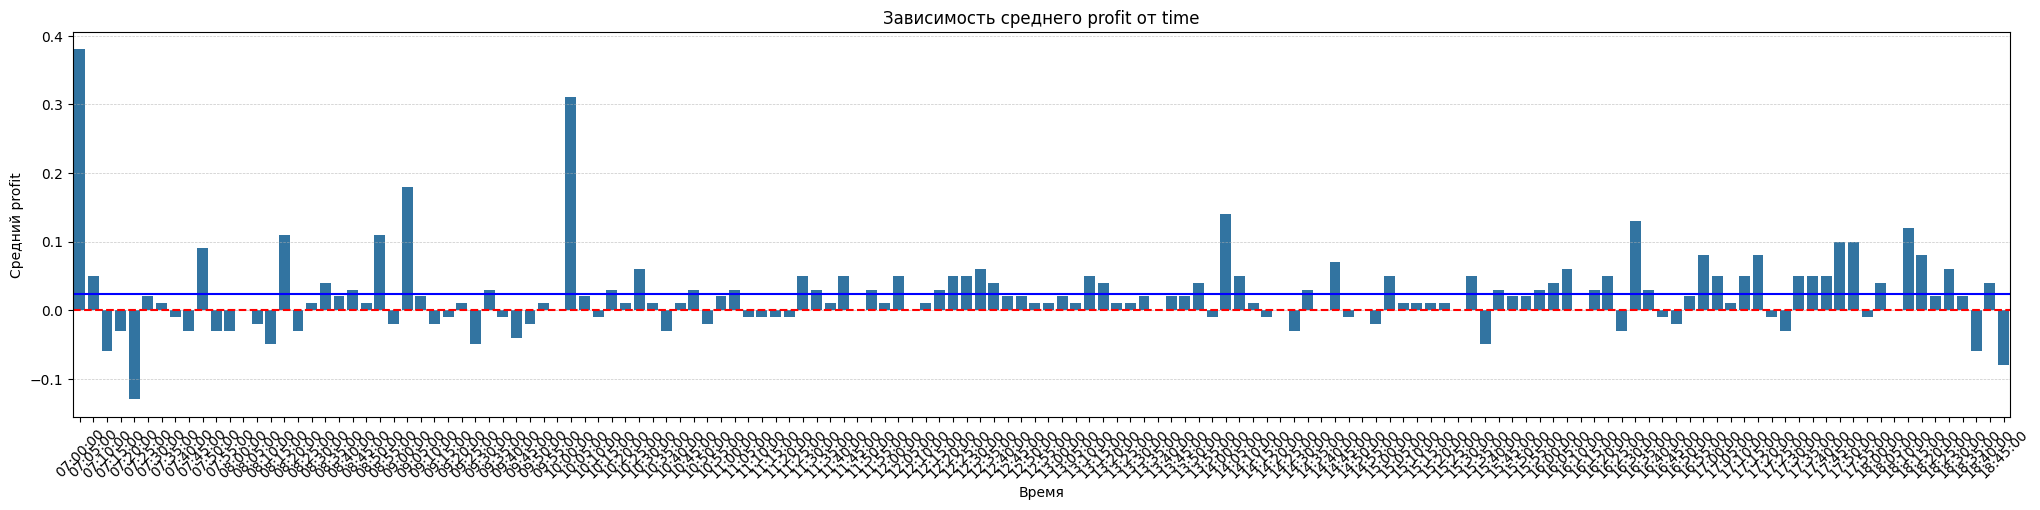

In [127]:
df_time = df_time.sort_values(by='time', ascending=True)

# Строим график зависимости
plt.figure(figsize=(25, 5))
sns.barplot(x=df_time['time'].astype(str), y=df_time['profit_avg'])

# Добавляем горизонтальные линии
plt.axhline(
    y=0, color='red', linestyle='--', linewidth=1.5, label='Уровень 0'
    )  # Пример линии на уровне 0
plt.axhline(
    y=df_time['profit_avg'].mean(), color='blue', linestyle='-', linewidth=1.5, 
    label='Средний profit'
    )  # Среднее значение

# Добавляем горизонтальную сетку
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)  # Только по оси Y

plt.xticks(rotation=45)  # Поворачиваем подписи оси X для читаемости
plt.title('Зависимость среднего profit от time')
plt.xlabel('Время')
plt.ylabel('Средний profit')
plt.show()

### Прибыль по сделкам за 15:30-18:20

In [128]:
# Фильтрация строк с 15:15:00
df_amer = df[
         (df["tradedate"].dt.time >= pd.to_datetime("15:30:00").time()) & 
         (df["tradedate"].dt.time <= pd.to_datetime("18:35:00").time())
]

df_amer

,tradedate,open,high,low,close,tvi,cci,t3,ghl,sig,sig_open,buy_sell,profit,date,time
8,2015-03-02 16:00:00,61.20,61.29,61.12,61.26,-1,-1,-1,-1,1,61.20,-1,0.27,2015-03-02,16:00:00
9,2015-03-02 16:40:00,60.92,61.09,60.87,61.08,-1,-1,-1,-1,1,60.92,-1,-0.28,2015-03-02,16:40:00
10,2015-03-02 18:05:00,61.19,61.30,60.97,61.26,1,1,1,1,1,61.19,1,-0.02,2015-03-02,18:05:00
11,2015-03-02 18:20:00,61.18,61.32,61.18,61.31,1,1,1,1,1,61.18,1,-0.28,2015-03-02,18:20:00
18,2015-03-03 15:55:00,60.97,61.01,60.77,60.92,-1,-1,-1,-1,1,60.97,-1,-0.03,2015-03-03,15:55:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23431,2024-12-28 15:30:00,74.05,74.05,74.04,74.04,-1,-1,-1,-1,1,74.05,-1,0.04,2024-12-28,15:30:00
23432,2024-12-28 16:15:00,74.00,74.01,73.99,74.01,-1,-1,-1,-1,1,74.00,-1,-0.06,2024-12-28,16:15:00
23440,2024-12-30 16:10:00,74.21,74.25,74.20,74.21,-1,-1,-1,-1,1,74.21,-1,-0.11,2024-12-30,16:10:00
23441,2024-12-30 16:35:00,74.31,74.34,74.28,74.30,1,1,1,1,1,74.31,1,0.06,2024-12-30,16:35:00


In [129]:
print(f'Средний профит на сделку: {df_amer['profit'].mean().round(4)}')

Средний профит на сделку: 0.0326


### Прибыль по дням  за 15:30-18:35

In [130]:
df_amer_date = (
    df_amer.groupby(['date'], as_index=False)
    .agg(
        total_profit=('profit', 'sum'),  # Сумма значений profit
        count_trade=('profit', 'count')  # Количество значений profit
    )
    # .sort_values(['total_profit'], ascending=False)
)

# df_amer_date.sort_values(by='date', ascending=True).to_excel('GMTS_даты_торговли.xlsx')

df_amer_date

,date,total_profit,count_trade
0,2015-03-02,-0.31,4
1,2015-03-03,0.18,4
2,2015-03-04,0.38,5
3,2015-03-05,-0.47,4
4,2015-03-06,0.21,3
...,...,...,...
2457,2024-12-25,-0.17,4
2458,2024-12-26,0.30,2
2459,2024-12-27,-0.09,4
2460,2024-12-28,-0.02,2


### Прибыль по месяцам за 15:30-18:35

In [131]:
df_tmp = df_amer.copy()

# Убедимся, что колонка с датой в формате datetime
df_tmp['date'] = pd.to_datetime(df_tmp['date'])

# Добавляем колонки для года и месяца
df_tmp['year_month'] = df_tmp['date'].dt.to_period('M')  # Год и месяц в формате YYYY-MM

# Группируем данные по году и месяцу
df_month_profit = (
    df_tmp.groupby('year_month')
    .agg(
        total_profit=('profit', 'sum'),    # Сумма прибыли за месяц
        total_trades=('profit', 'count')  # Количество сделок за месяц
    )
    .reset_index()
)

# # Если нужно, преобразуем 'year_month' обратно в строку
# month_profit['year_month'] = month_profit['year_month'].astype(str)

df_month_profit['dollar'] = df_month_profit['total_profit'] * 0.02

# df_month_profit.sort_values(by='year_month', ascending=True) \
#     .to_excel('GMTS_прибыль_месяца_15-19.xlsx', index=False)

df_month_profit

,year_month,total_profit,total_trades,dollar
0,2015-03,2.36,73,0.0472
1,2015-04,1.89,75,0.0378
2,2015-05,3.02,53,0.0604
3,2015-06,3.77,70,0.0754
4,2015-07,-1.53,81,-0.0306
...,...,...,...,...
113,2024-08,6.09,74,0.1218
114,2024-09,2.98,83,0.0596
115,2024-10,7.88,72,0.1576
116,2024-11,5.71,68,0.1142


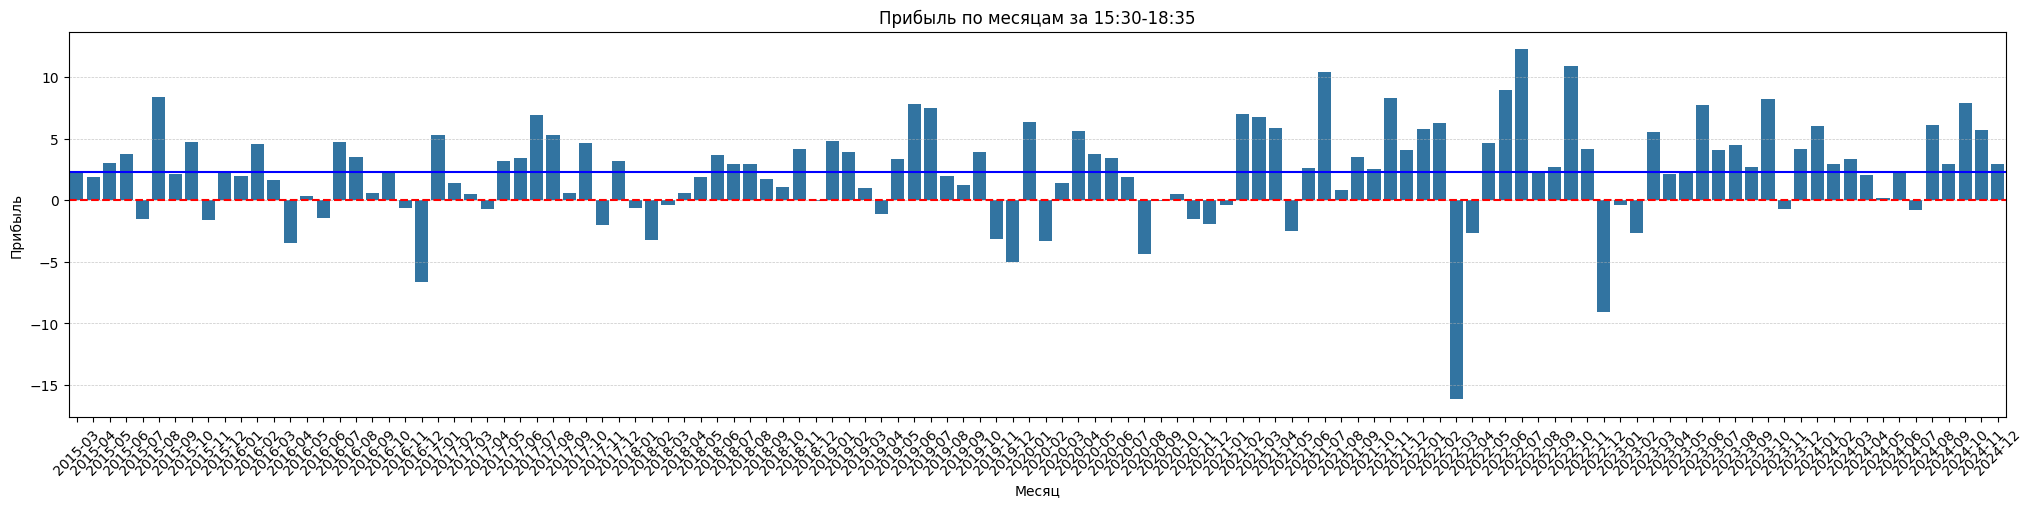

In [132]:
df_month_profit = df_month_profit.sort_values(by='year_month', ascending=True)

# Строим график зависимости
plt.figure(figsize=(25, 5))
sns.barplot(x=df_month_profit['year_month'].astype(str), y=df_month_profit['total_profit'])

# Добавляем горизонтальные линии
plt.axhline(
    y=0, color='red', linestyle='--', linewidth=1.5, label='Уровень 0'
    )  # Пример линии на уровне 0
plt.axhline(
    y=df_month_profit['total_profit'].mean(), color='blue', linestyle='-', linewidth=1.5, 
    label='Средний profit'
    )  # Среднее значение

# Добавляем горизонтальную сетку
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)  # Только по оси Y

plt.xticks(rotation=45)  # Поворачиваем подписи оси X для читаемости
plt.title('Прибыль по месяцам за 15:30-18:35')
plt.xlabel('Месяц')
plt.ylabel('Прибыль')
plt.show()

### График комулятивной прибыли за 15:30-18:35

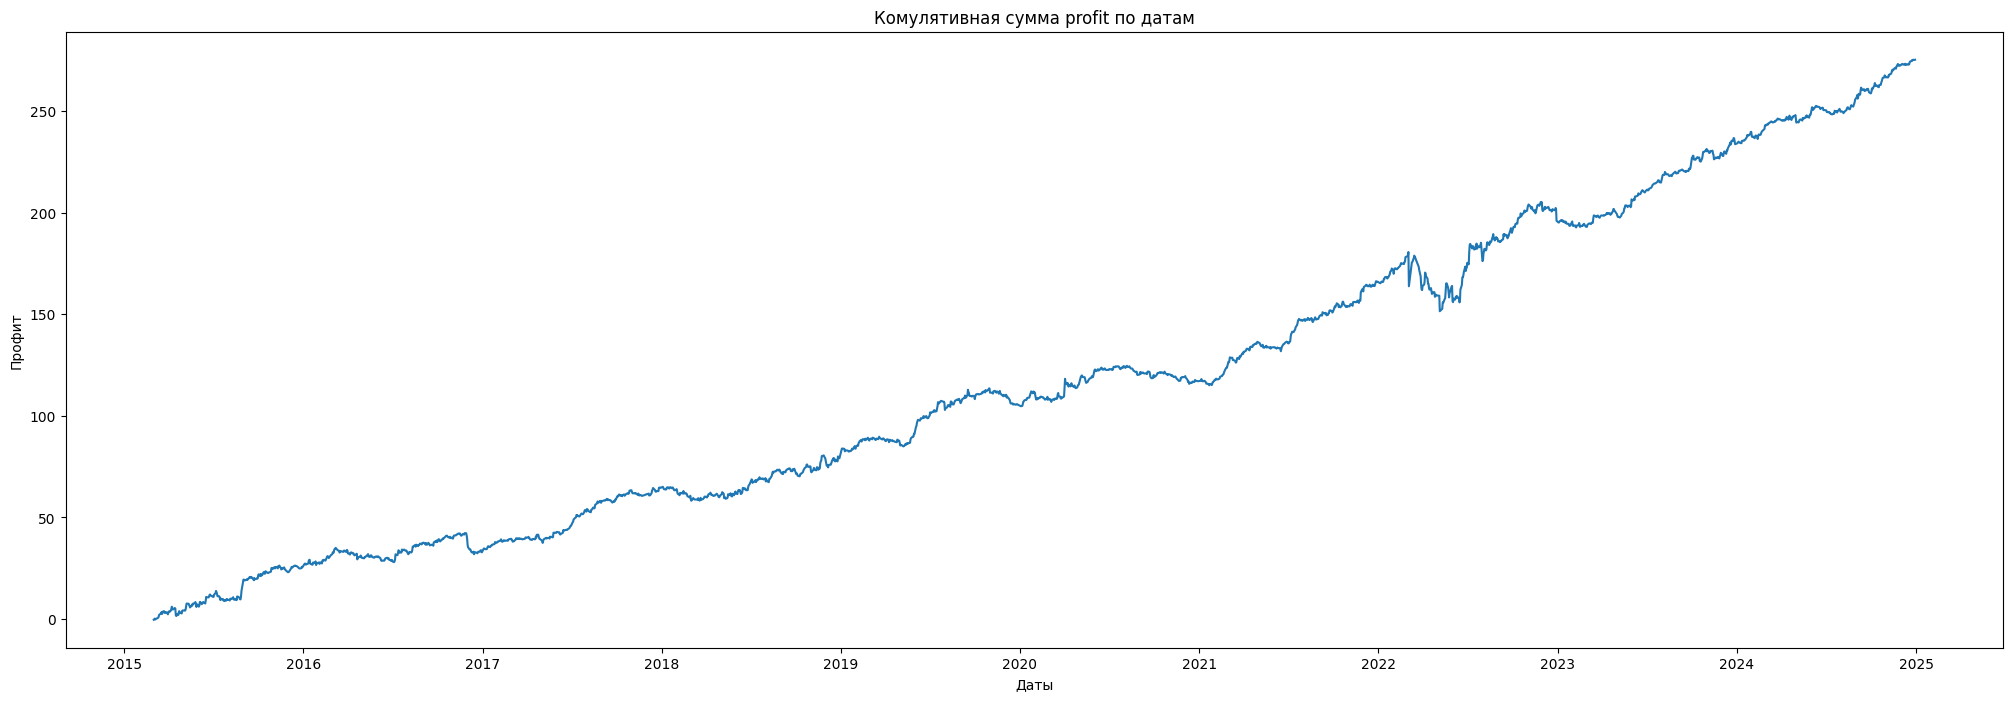

In [133]:
df_amer_date['sum_profit'] = df_amer_date['total_profit'].cumsum()

plt.figure(figsize=(25, 8))
sns.lineplot(data=df_amer_date, x=df_amer_date['date'], y='sum_profit')
plt.title('Комулятивная сумма profit по датам')
plt.xlabel('Даты')
plt.ylabel('Профит')
plt.show()



# Прибыль за две сессии 10:05-14:10 и 15:15-18:30

In [134]:
# Фильтрация строк
df_2 = df[
         (df["tradedate"].dt.time >= pd.to_datetime("10:05:00").time()) & 
         (df["tradedate"].dt.time <= pd.to_datetime("14:10:00").time()) |
         (df["tradedate"].dt.time >= pd.to_datetime("15:15:00").time()) & 
         (df["tradedate"].dt.time <= pd.to_datetime("18:30:00").time())
]

df_2

,tradedate,open,high,low,close,tvi,cci,t3,ghl,sig,sig_open,buy_sell,profit,date,time
0,2015-03-02 10:15:00,62.03,62.03,61.83,61.84,-1,-1,-1,-1,1,62.03,-1,-0.05,2015-03-02,10:15:00
1,2015-03-02 11:05:00,62.07,62.18,61.96,62.00,1,1,1,1,1,62.07,1,0.04,2015-03-02,11:05:00
2,2015-03-02 12:00:00,62.12,62.13,62.00,62.08,1,1,1,1,1,62.12,1,0.08,2015-03-02,12:00:00
3,2015-03-02 12:45:00,62.21,62.22,62.12,62.21,1,1,1,1,1,62.21,1,-0.18,2015-03-02,12:45:00
4,2015-03-02 13:10:00,62.04,62.08,61.95,62.02,-1,-1,-1,-1,1,62.04,-1,0.05,2015-03-02,13:10:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23437,2024-12-30 13:10:00,73.90,73.91,73.86,73.90,-1,-1,-1,-1,1,73.90,-1,-0.18,2024-12-30,13:10:00
23438,2024-12-30 13:45:00,74.07,74.08,74.05,74.05,1,1,1,1,1,74.07,1,-0.02,2024-12-30,13:45:00
23440,2024-12-30 16:10:00,74.21,74.25,74.20,74.21,-1,-1,-1,-1,1,74.21,-1,-0.11,2024-12-30,16:10:00
23441,2024-12-30 16:35:00,74.31,74.34,74.28,74.30,1,1,1,1,1,74.31,1,0.06,2024-12-30,16:35:00


In [135]:
print(f'Средний профит на сделку: {df_2['profit'].mean().round(4)}')

Средний профит на сделку: 0.026


### Прибыль по дням за 2 сессии

In [136]:
df_2_date = (
    df_2.groupby(['date'], as_index=False)
    .agg(
        total_profit=('profit', 'sum'),  # Сумма значений profit
        count_trade=('profit', 'count')  # Количество значений profit
    )
    # .sort_values(['total_profit'], ascending=False)
)

# df_2_date.sort_values(by='date', ascending=True).to_excel('GMTS_даты_торговли.xlsx')

df_2_date

,date,total_profit,count_trade
0,2015-03-02,-0.17,10
1,2015-03-03,0.13,9
2,2015-03-04,0.70,9
3,2015-03-05,-0.28,9
4,2015-03-06,-0.20,8
...,...,...,...
2479,2024-12-25,-0.20,7
2480,2024-12-26,0.46,4
2481,2024-12-27,-0.11,9
2482,2024-12-28,-0.26,8


### Прибыль по месяцам за две сессии

In [137]:
df_tmp = df_tmp.iloc[0:0]
df_month_profit = df_month_profit.iloc[0:0]

df_tmp = df_2.copy()

# Убедимся, что колонка с датой в формате datetime
df_tmp['date'] = pd.to_datetime(df['date'])

# Добавляем колонки для года и месяца
df_tmp['year_month'] = df_tmp['date'].dt.to_period('M')  # Год и месяц в формате YYYY-MM

# Группируем данные по году и месяцу
df_month_profit = (
    df_tmp.groupby('year_month')
    .agg(
        total_profit=('profit', 'sum'),    # Сумма прибыли за месяц
        total_trades=('profit', 'count')  # Количество сделок за месяц
    )
    .reset_index()
)

# # Если нужно, преобразуем 'year_month' обратно в строку
# month_profit['year_month'] = month_profit['year_month'].astype(str)

df_month_profit['dollar'] = df_month_profit['total_profit'] * 0.02

# df_month_profit.sort_values(by='year_month', ascending=True) \
#     .to_excel('GMTS_прибыль_месяца_15-19.xlsx', index=False)

df_month_profit

,year_month,total_profit,total_trades,dollar
0,2015-03,-1.15,172,-0.0230
1,2015-04,4.16,162,0.0832
2,2015-05,4.88,128,0.0976
3,2015-06,9.97,163,0.1994
4,2015-07,-0.45,165,-0.0090
...,...,...,...,...
113,2024-08,6.11,174,0.1222
114,2024-09,1.03,166,0.0206
115,2024-10,12.86,172,0.2572
116,2024-11,8.37,157,0.1674


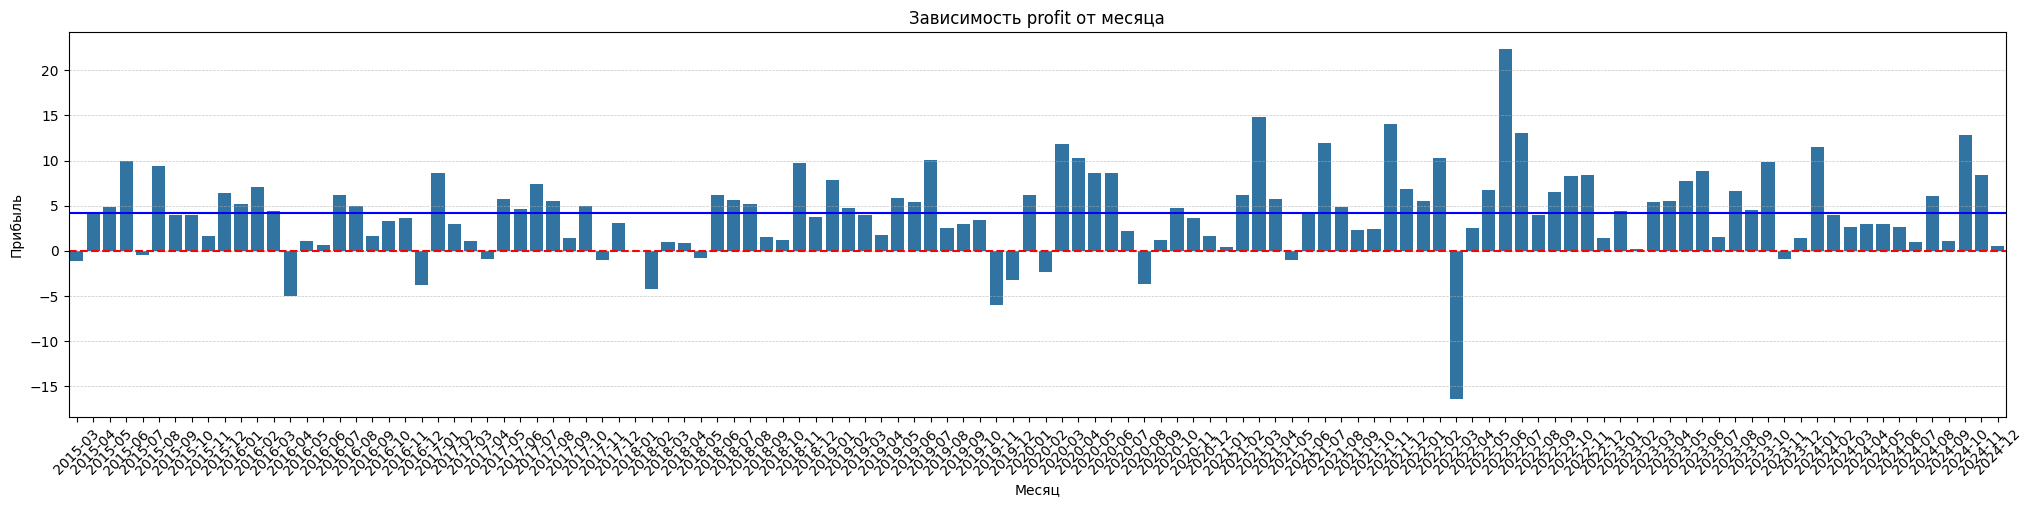

In [138]:
df_month_profit = df_month_profit.sort_values(by='year_month', ascending=True)

# Строим график зависимости
plt.figure(figsize=(25, 5))
sns.barplot(x=df_month_profit['year_month'].astype(str), y=df_month_profit['total_profit'])

# Добавляем горизонтальные линии
plt.axhline(
    y=0, color='red', linestyle='--', linewidth=1.5, label='Уровень 0'
    )  # Пример линии на уровне 0
plt.axhline(
    y=df_month_profit['total_profit'].mean(), color='blue', linestyle='-', linewidth=1.5, 
    label='Средний profit'
    )  # Среднее значение

# Добавляем горизонтальную сетку
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)  # Только по оси Y

plt.xticks(rotation=45)  # Поворачиваем подписи оси X для читаемости
plt.title('Зависимость profit от месяца')
plt.xlabel('Месяц')
plt.ylabel('Прибыль')
plt.show()

### График комулятивной прибыли для 2 сессий

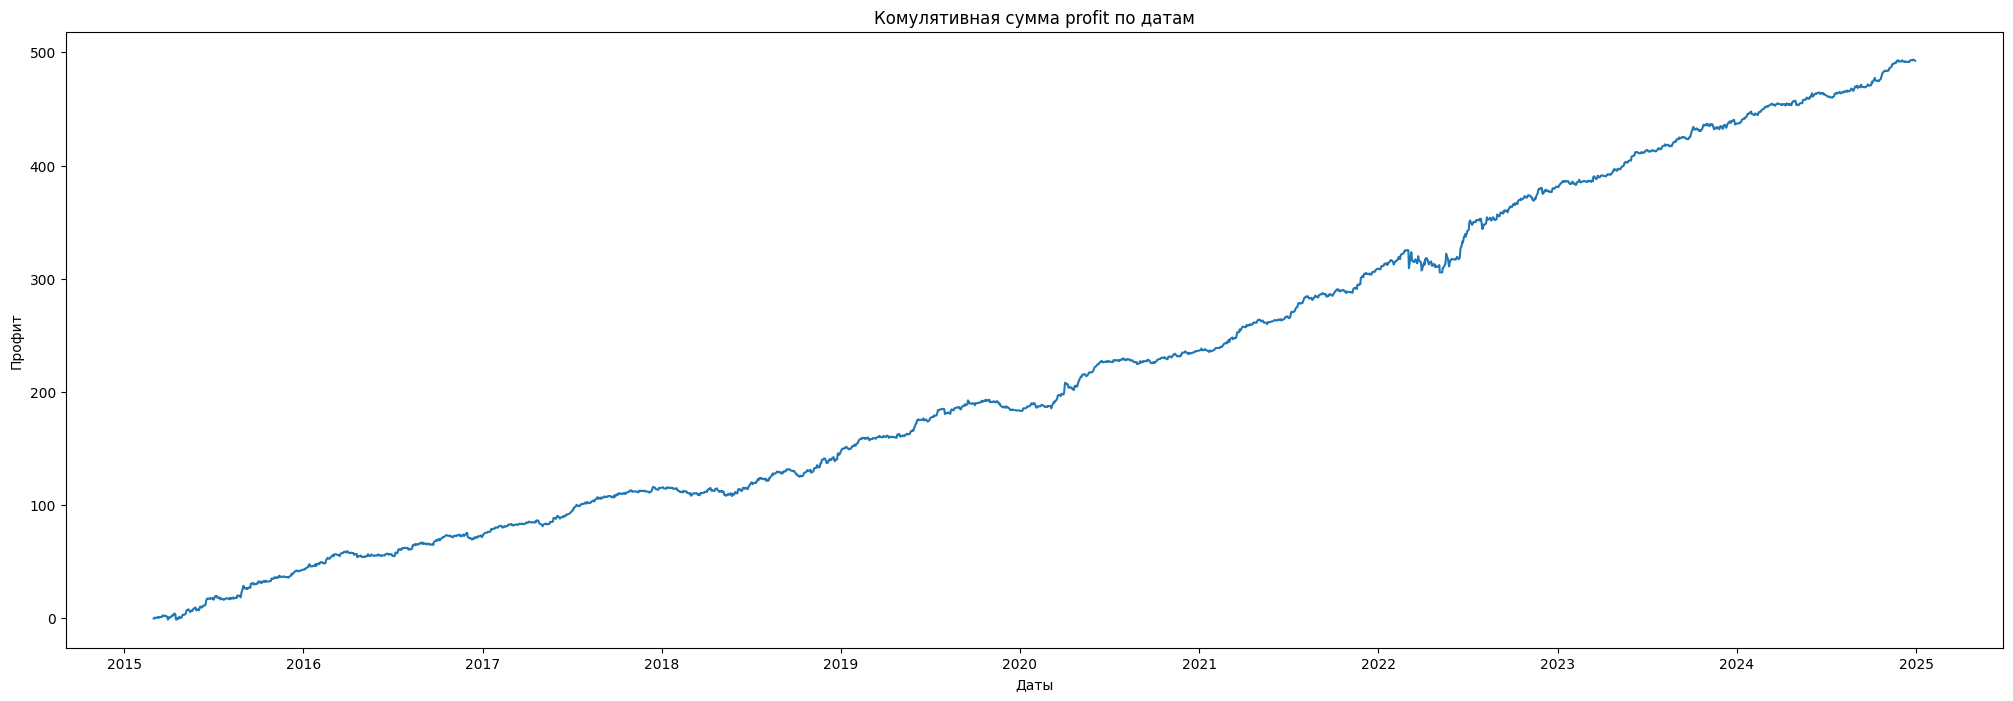

In [139]:
df_2_date['sum_profit'] = df_2_date['total_profit'].cumsum()

plt.figure(figsize=(25, 8))
sns.lineplot(data=df_2_date, x=df_2_date['date'], y='sum_profit')
plt.title('Комулятивная сумма profit по датам')
plt.xlabel('Даты')
plt.ylabel('Профит')
plt.show()

